In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
from itertools import groupby
import numpy as np
import cv2
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
from glob import glob
from multiprocessing import Pool
import matplotlib.pyplot as plt
# import cupy as cp
import ast
from pathlib import Path
import pickle5 as pickle
import torch

import shutil
import sys
sys.path.append("../src/")
sys.path.append("../yolov5/")

import util

from joblib import Parallel, delayed

from mmdet.apis import init_detector, inference_detector

from IPython.display import display, HTML
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.model import Yolov5DetectionModel
from sahi.predict import get_prediction, get_sliced_prediction, predict
from ensemble_boxes import weighted_boxes_fusion

from IPython.display import Image
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [3]:
CONF = 0.01
IOU = 0.4
AUGMENT = True # True 

In [4]:
# add augmentation choice
def perform_inference(self, image, image_size, augment=AUGMENT):
    try:
        import yolov5
    except ImportError:
        raise ImportError('Please run "pip install -U yolov5" ' "to install YOLOv5 first for YOLOv5 inference.")

    # Confirm model is loaded
    assert self.model is not None, "Model is not loaded, load it by calling .load_model()"

    if image_size is not None:
        warnings.warn("Set 'image_size' at DetectionModel init.", DeprecationWarning)
        prediction_result = self.model(image, size=image_size, augment=augment)
    elif self.image_size is not None:
        prediction_result = self.model(image, size=self.image_size, augment=augment)
    else:
        prediction_result = self.model(image, augment=augment)
    self._original_predictions = prediction_result
    return 

Yolov5DetectionModel.perform_inference = perform_inference

In [5]:
model_versions = ['0211_m6_B_LS02_LGBT_newP_clahe']
CUDA = "cuda:0"
run_all=False
pre_name = ''

# Load Data

In [6]:
INPUT_DIR = Path("../../data/tensorflow-great-barrier-reef/")
df = pd.read_csv(INPUT_DIR / "train.csv")
folds = util.load_pickle("../input/fold_test_2.pkl")
df["fold"] = df["sequence"].apply(lambda x: folds[x])
highFP_df = pd.read_csv('../input/df_highFPNoBB.csv')
df = pd.merge(df, highFP_df[['video_id',"video_frame","highFBNoBB"]], on=["video_id","video_frame"], how='left')
df["highFBNoBB"].fillna(False, inplace=True)

df.shape

(23501, 8)

In [7]:
data_param = {'root_dir':INPUT_DIR,'label_dir':INPUT_DIR / "labels"}
df = df.progress_apply(lambda x: util.get_path(x, data_param, infer=True), axis=1)
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df["real_bbox"] = df["annotations"].apply(lambda annots: [list(annot.values()) for annot in annots])
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts(normalize=True)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

No BBox: 79.07% | With BBox: 20.93%


In [8]:
df['train'] = False
df.loc[df.query("fold == 0 and (num_bbox > 0 or highFBNoBB)").index, 'train'] = True
df['train'].value_counts()

False    19173
True      4328
Name: train, dtype: int64

In [9]:
# COTS per frame
df.groupby("fold").apply(lambda df: df["num_bbox"].sum() / df.shape[0])

fold
0    0.549803
1    0.332484
dtype: float64

In [10]:
df['fold'].value_counts(normalize=True)

0    0.799711
1    0.200289
Name: fold, dtype: float64

# Model

In [11]:
meta_params = {}
for model_version in model_versions:
    model_folder = Path(f"../output/{model_version}/")
    try:
        params_path = model_folder / "config" / "params.pkl"
        params = pickle.load(open(params_path, 'rb'))
    except:
        params_path = model_folder / "config" / "params.yaml"
        params = util.load_yaml(params_path)
        
    for key, val in params.items():
        if "dir" in key or "path" in key or "file" in key:
            params[key] = Path(val)
    meta_params[model_version] = params

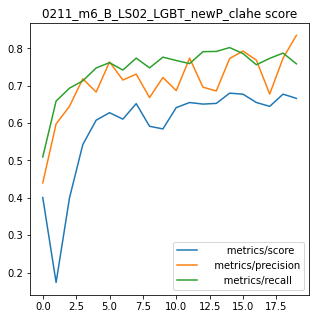

In [12]:
fig, axes = plt.subplots(1, len(meta_params),figsize=(5*len(meta_params), 5))
if len(meta_params) == 1:
    axes = [axes]
target_score = {}
for i,(model_version, params) in enumerate(meta_params.items()):
    if params["tools"] == "mmdetection":
        continue
    logging_dir = params["ckpt_path"].parent.parent
    res_df = pd.read_csv(logging_dir / "results.csv")    
    res_df[['       metrics/score','   metrics/precision', '      metrics/recall']].plot(ax=axes[i])
    axes[i].legend()
    axes[i].set_title(f"{model_version} score")    
    target_score[model_version] = res_df['       metrics/score'].max()
plt.show()    

In [13]:
target_score

{'0211_m6_B_LS02_LGBT_newP_clahe': 0.68005}

In [14]:
params['img_size']

2300

In [15]:
models = {}
for model_version, params in meta_params.items():
    if params['tools'] == "yolov5":
        params["repo"] = Path("../yolov5/").resolve()
    else:
        ckp = glob(str(params['output_dir']) + "/" + "latest*")[0]
        params['ckpt_path'] = ckp
    params["augment"]  = AUGMENT
    params["conf"] = CONF
    params["iou"] = IOU

    if "slice" in model_version:
        model = Yolov5DetectionModel(
            model_path=str(params['ckpt_path']),
            confidence_threshold=0.01,
            image_size = int(params['img_size'] * 1.3),
            device=CUDA, # or 'cuda:0'
        )    
    else:
        if params['tools']  == "yolov5":
            model = util.load_model(params)
            device = torch.device(CUDA)
            model.to(device)
        elif params['tools'] == "mmdetection":
            model = init_detector(str(params['cfg_dir'] / "config.py"), ckp, device=CUDA)
    models[model_version] = model

YOLOv5 🚀 v6.0-191-g05ff176 torch 1.10.1+cu102 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11016MiB)

Fusing layers... 
Model Summary: 378 layers, 35248920 parameters, 0 gradients, 49.0 GFLOPs
Adding AutoShape... 


In [16]:
#print(model.cfg.pretty_text)

# Prediction

In [17]:
#df["pred"] = None
for model_version in meta_params.keys():
    df["pred_" + model_version] = None
df.columns

Index(['video_id', 'sequence', 'video_frame', 'sequence_frame', 'image_id',
       'annotations', 'fold', 'highFBNoBB', 'old_image_path', 'image_path',
       'label_path', 'real_bbox', 'num_bbox', 'train',
       'pred_0211_m6_B_LS02_LGBT_newP_clahe'],
      dtype='object')

In [18]:
SH = 720
SW = 720
OHR = 0.2
OWR = 0.2
PMT = 0.4
clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(10, 10))
for idx in tqdm(range(len(df))):
    row = df.loc[idx]
    target_fold = row['fold']
    if (not run_all) and (target_fold != 1):
        continue
    img_path = row["image_path"]
    img = cv2.imread(str(img_path))
    for model_version, model in models.items():
        SIZE = int(meta_params[model_version]["img_size"] * 1.3)
        #SIZE = 6000
        pred_col = "pred_" + model_version
        if row[pred_col] is not None:
            continue
        USE_CLACHE = meta_params[model_version].get("use_clahe", True)
        img2 = img.copy()
        if USE_CLACHE:
            for i in range(3):
                img2[:, :, i] = clahe.apply((img2[:, :, i]))     
                
        if meta_params[model_version]["tools"] == "yolov5":
            img2 = img2[...,::-1]
            if "slice" in model_version:
                result_sliced = get_sliced_prediction(
                    img2,
                    model,
                    slice_height = SH,
                    slice_width = SW,
                    overlap_height_ratio = OHR,
                    overlap_width_ratio = OWR,
                    postprocess_match_threshold = PMT,
                    verbose = False)
                object_prediction_list = result_sliced.object_prediction_list
                confs = [obj_pred.score.value for obj_pred in object_prediction_list]
                pred_bbox = np.array([obj_pred.bbox.to_coco_bbox() for obj_pred in object_prediction_list])
            else:
                pred_bbox, confs = util.predict(model, img2, size=SIZE, augment=AUGMENT, use_sahi=False)

        elif meta_params[model_version]["tools"] == "mmdetection":
            result = inference_detector(model, img2)
            pred_bbox = result[0][:,:4]
            pred_bbox[:,2:] = pred_bbox[:,2:] - pred_bbox[:,:2]
            pred_confs = result[0][:,4]
            confs = pred_confs.tolist()
        df.at[idx, pred_col] = [ [conf] + pred_bbox[i].tolist() for i, conf in enumerate(confs)]

  0%|          | 0/23501 [00:00<?, ?it/s]

In [21]:
#save it
name = pre_name + f"pred_{model_versions[0]}.pkl"
if run_all:
    name = "whole_" + name
name = "./oof_pred/" + name
util.save_pickle(df, name)

In [22]:
name

'./oof_pred/pred_0211_m6_B_LS02_LGBT_newP_clahe.pkl'